
## Setting up the environment and loading data



In [ ]:
 !pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
# Download data
!kaggle competitions download -c kkbox-churn-prediction-challenge

 29% 9.00M/31.3M [00:00<00:01, 22.8MB/s]
100% 31.3M/31.3M [00:00<00:00, 70.7MB/s]
100% 6.64G/6.65G [01:40<00:00, 30.8MB/s]
100% 6.65G/6.65G [01:40<00:00, 70.9MB/s]
 97% 225M/231M [00:02<00:00, 75.6MB/s]
100% 231M/231M [00:03<00:00, 80.2MB/s]
 88% 41.0M/46.6M [00:00<00:00, 39.0MB/s]
100% 46.6M/46.6M [00:00<00:00, 68.3MB/s]
 99% 669M/675M [00:08<00:00, 65.2MB/s]
100% 675M/675M [00:08<00:00, 87.0MB/s]
 53% 17.0M/32.0M [00:00<00:00, 22.3MB/s]
100% 32.0M/32.0M [00:00<00:00, 65.2MB/s]
100% 31.3M/31.3M [00:00<00:00, 26.7MB/s]

 99% 29.0M/29.2M [00:00<00:00, 19.6MB/s]
100% 29.2M/29.2M [00:00<00:00, 59.6MB/s]
  0% 0.00/6.88k [00:00<?, ?B/s]
100% 6.88k/6.88k [00:00<00:00, 7.07MB/s]
 98% 640M/654M [00:07<00:00, 91.0MB/s]
100% 654M/654M [00:07<00:00, 91.7MB/s]


In [ ]:
%ls

kaggle.json                    train_v2.csv.7z
members_v3.csv.7z              transactions.csv.7z
sample_data/                   transactions_v2.csv.7z
sample_submission_v2.csv.7z    user_logs.csv.7z
sample_submission_zero.csv.7z  user_logs_v2.csv.7z
train.csv.7z                   WSDMChurnLabeller.scala


In [ ]:
!pip install pyunpack
!pip install patool

  Created wheel for pyunpack: filename=pyunpack-0.1.2-cp36-none-any.whl size=5163 sha256=f95660fc80917cae1bfa73759a4b72e1209161aec18bbe0e85cfc37926e559ab
  Stored in directory: /root/.cache/pip/wheels/af/44/08/60613970881e542c0baad1f2dea5ed8e6716bc573f49197b7e
Successfully built pyunpack
     |████████████████████████████████| 81kB 5.4MB/s 


In [ ]:
# Unpack data
from pyunpack import Archive
Archive('train.csv.7z').extractall("/content/")
Archive('members_v3.csv.7z').extractall("/content/")
# Archive('user_logs.csv.7z').extractall("/content/") -- too large for colab
Archive('transactions.csv.7z').extractall("/content/")

In [ ]:
import pandas as pd
df_train = pd.read_csv('train.csv')
members = pd.read_csv('members_v3.csv')
transactions = pd.read_csv('transactions.csv')

In [ ]:
# Feature extraction
members['reg_month'] = members.registration_init_time.apply(lambda x : str(x)[-2:])
members['reg_year'] = members.registration_init_time.apply(lambda x : str(x)[:3])

In [ ]:
# Adjust datatypes for memory efficiency
import numpy as np
def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)


def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)
        
change_datatype(members)
change_datatype_float(members)
change_datatype(transactions)
change_datatype_float(transactions)

In [ ]:
# Feature engineering
transactions['discount'] = transactions['plan_list_price'] - transactions['actual_amount_paid']
transactions['is_discount'] = transactions.discount.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
transactions['price_per_day'] = transactions['actual_amount_paid'] / transactions['payment_plan_days']
transactions['membership_duration'] = transactions.membership_expire_date - transactions.transaction_date

In [ ]:
# Merge datasets
data = pd.merge(transactions, members, on='msno')

In [ ]:
data

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,discount,is_discount,price_per_day,membership_duration,city,bd,gender,registered_via,registration_init_time,reg_month,reg_year
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0,0,0,4.300000,171,1,0,NaN,7,20110629,29,201
1,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20151031,20151201,0,0,0,4.300000,170,1,0,NaN,7,20110629,29,201
2,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150630,20150801,0,0,0,4.300000,171,1,0,NaN,7,20110629,29,201
3,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150228,20150401,0,0,0,4.300000,173,1,0,NaN,7,20110629,29,201
4,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20161130,20170101,0,0,0,4.300000,8971,1,0,NaN,7,20110629,29,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18891698,ON/0c5eeg3wKmtjyvjvCrza8959BpFO0T+5BwP5+duI=,22,395,1599,1599,0,20150818,20160921,0,0,0,4.048101,10103,6,30,male,9,20060305,05,200
18891699,jQl+rtRwQMvHJc4jWO+Mj5f5EDvz+m04x7ASAFQ+pzo=,35,7,0,0,0,20161031,20161107,0,0,0,0.000000,76,5,32,female,3,20150818,18,201
18891700,mvE2SExeEtdT1RTspjWkjiVuZ+0uQUn3+rC7Hdv39p0=,17,195,0,0,0,20150111,20150114,0,0,0,0.000000,3,13,22,male,3,20150104,04,201
18891701,5NAqLKaOrvwIA39T2ylqkSQ+1U6oiZbPDBGyRlxoio0=,38,30,149,149,0,20170131,20170302,0,0,0,4.966667,171,1,0,NaN,9,20130502,02,201


In [ ]:
data = pd.merge(data, df_train, on='msno')

## Explanatory analysis



In [ ]:
# Imbalanced data
data.groupby('is_churn').count().msno

is_churn
0    13659207
1      623189
Name: msno, dtype: int64

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.1)

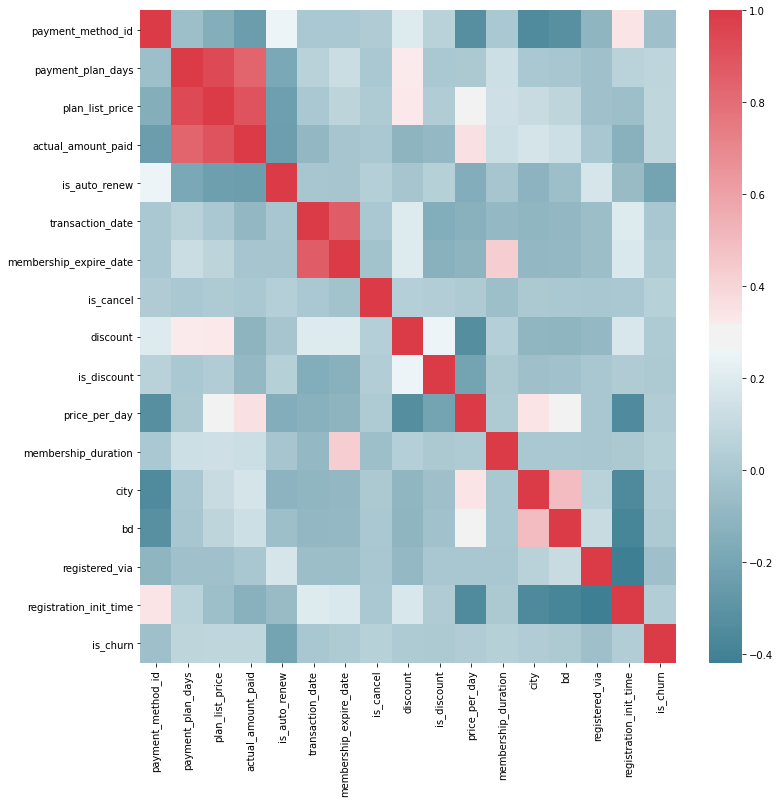

In [ ]:
# No highly-correlated variable for is_churn - probably because it's binary
# https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(12, 12))
corr = train_df.corr()
sns.heatmap(corr, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            ax=ax)

In [ ]:
# Correlation of binary vars - is_churn to -auto_renew, is_cancel, is_discount
def contigency_table(var1, var2):
  a = data[var1] > 0
  b = data[var2] > 0
  return (data.groupby([a,b]).count() / data.count()).msno

print(contigency_table('is_churn', 'is_auto_renew'))
print(contigency_table('is_churn', 'is_cancel'))
print(contigency_table('is_churn', 'is_discount'))

is_churn  is_auto_renew
False     False            0.067841
          True             0.888525
True      False            0.015420
          True             0.028213
Name: msno, dtype: float64
is_churn  is_cancel
False     False        0.940084
          True         0.016283
True      False        0.041401
          True         0.002232
Name: msno, dtype: float64
is_churn  is_discount
False     False          0.937925
          True           0.018442
True      False          0.042388
          True           0.001245
Name: msno, dtype: float64


In [ ]:
# A bit of cleaning
# data = data.replace([np.inf, -np.inf], np.nan)
# data.dropna(inplace=True)

train_df = train_df.replace([np.inf, -np.inf], np.nan)
train_df.dropna(inplace=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
# Correlation of churn to continious variables
# Use logistic regression to determine goodness of fit as a proxy for predicting power
def log_reg_goodness_of_fit(var1):
  lr = LogisticRegression(random_state=42, class_weight='balanced')
  lr.fit(data[var1].values.reshape(-1, 1), data.is_churn)
  pred = lr.predict(data[var1].values.reshape(-1, 1))
  return var1, f1_score(data.is_churn, pred)

print(log_reg_goodness_of_fit('price_per_day'))
print(log_reg_goodness_of_fit('payment_plan_days'))
print(log_reg_goodness_of_fit('plan_list_price'))
print(log_reg_goodness_of_fit('actual_amount_paid'))
print(log_reg_goodness_of_fit('discount'))

('price_per_day', 0.08559932725273303)
('payment_plan_days', 0.09279566976973057)
('plan_list_price', 0.13029828163838755)
('actual_amount_paid', 0.12950635498585525)
('discount', 0.030091236778075396)


## Initial modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
class_weight = {1: 0.9, 0:0.1}
rfc = RandomForestClassifier(max_depth = 25,
                             n_estimators=100,
                             max_features=5,
                             min_samples_split=2,
                             bootstrap=True,
                             min_samples_leaf = 1,
                             class_weight=class_weight, 
                             criterion='gini',
                             random_state=42)
rfc.fit(train_df.drop(['msno', 'transaction_date', 'membership_expire_date', 'bd', 'registration_init_time', 'is_churn', 'membership_duration', 'gender'], axis=1), train_df.is_churn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.1, 1: 0.9}, criterion='gini',
                       max_depth=25, max_features=5, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [ ]:
# pred = rfc.predict(train_df.drop(['msno', 'transaction_date', 'membership_expire_date', 'bd', 'registration_init_time', 'is_churn', 'membership_duration', 'gender'], axis=1))
f1_score(train_df.is_churn, pred) # -- low f1 score

0.3264571930092198

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
accuracy_score(train_df.is_churn, pred)

0.8788024884656199

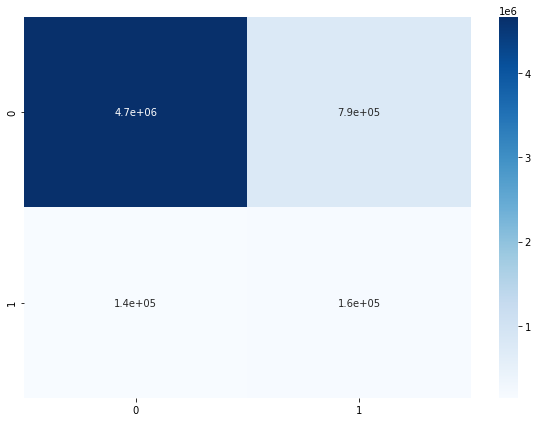

In [ ]:
# Not useful at predicting positive class 
cm = confusion_matrix(train_df.is_churn, pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap = plt.get_cmap('Blues'))

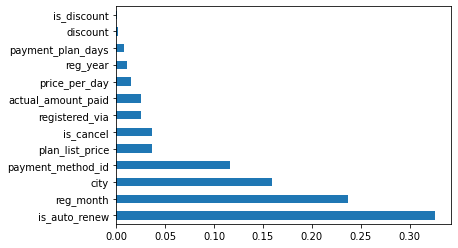

In [ ]:
# How reliable are this results?
feat_importances = pd.Series(rfc.feature_importances_, index=train_df.drop(['msno', 'transaction_date', 'membership_expire_date', 'bd', 'registration_init_time', 'is_churn', 'membership_duration', 'gender'], axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')